![](https://www.rossmann-cdn.de/dam/jcr:6497cb16-d30b-4f0a-b442-aad2613bf879/cor-presse-logo-rossmann.2015-12-07-16-37-10.png)

On my learning-journey to become a good data scientist, I also had to stop by the Rossmann dataset. Not because we have a Rossmann store near our house. It's because, I am also dealing in my daily job-life with time series datasets, understanding and making predictions from it.  

I will go trough the following steps:

**Exploratory Data Analysis (EDA)**

* Problem definition (what do we want to solve)
* Variable Identification (what data do we have)
* Univariate Analysis (understanding each field in the dataset)
* Multivariate Analysis (understanding the interactions between different fields and target)
* Missig values treatment (machine learning algorythems hates fields with missing data)
* Outlier treatment
* Variable transformation / creation

**Predictive Modeling**
* SARIMAX
* Prophet
* Random Forest Regression
* XGBoost

Now get prepared, by sitting on your favorite chair in a room with a glass Wine or Cola, because this can be a long read.

# Problem definition

We have the following informations from rossmann in two different tables:

* **Id**: An Id that represents a (Store, Date) duple within the test set
* **Store**: A unique Id for each store
* **Sales**: The turnover on a given day (our target variable)
* **Customers**: The number of customers on a given day
* **Open**: open: 0 = the store is closed , 1 = the store is open
* **StateHoliday**: Indicates a state holiday. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday**: Store on this Date was affected or not by the closure of public schools
* **StoreType**: 4 different stores:a,b,c,d
* **Assortment**: a = basic, b = extra, c = extended
* **CompetitionDistance**: Distance in meters to the nearest competitor store
* **CompetitionOpenSince**[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* **Promo**: Promo or not on that day
* **Promo2**: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since**[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* **PromoInterval**: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

With all this information we have to predict the sales for the next 6 weeks. 

In [1]:
# lets import the libraries we need for EDA:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.style.use("ggplot") # to make the plots to look nicer
import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'store.csv', 'sample_submission.csv']


In [2]:
#lets import the training and test files:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
store_df = pd.read_csv("../input/store.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#how many datas are in the files:
print("in the training set we have", train_df.shape[0], "observations and", train_df.shape[1], "columns/variables.")
print("in the testing set we have", test_df.shape[0], "observations and", test_df.shape[1], "columns/variables.")
print("in the store set we have", store_df.shape[0], "observations and", store_df.shape[1], "columns/variables.")

in the training set we have 1017209 observations and 9 columns/variables.
in the testing set we have 41088 observations and 8 columns/variables.
in the store set we have 1115 observations and 10 columns/variables.


# Lets start first with understanding and cleaning the **training dataset.**

In [4]:
#how does the data looks like:
train_df.head().append(train_df.tail()) #show the first and last 5 rows.

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [5]:
#wow. no missing values.
train_df.isnull().all()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

Lets start with the first variable -> **Sales**

In [6]:
opened_sales = (train_df[(train_df.Open == 1) & (train_df.Sales)]) #if the stores are opend
opened_sales.Sales.describe()

count    422307.000000
mean       6951.782199
std        3101.768685
min         133.000000
25%        4853.000000
50%        6367.000000
75%        8355.000000
max       41551.000000
Name: Sales, dtype: float64

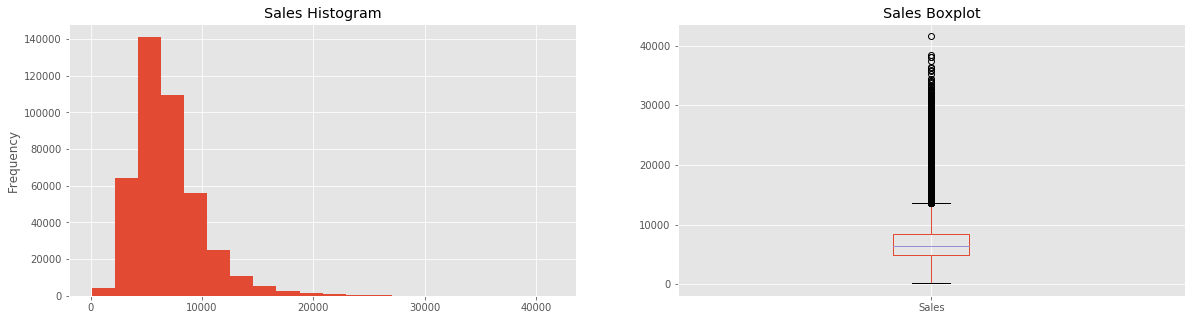

In [7]:
f, ax = plt.subplots(1,2, figsize = (20, 5))

opened_sales.Sales.plot(kind = "hist", title = "Sales Histogram", bins = 20, ax = ax[0])
opened_sales.Sales.plot.box(title = "Sales Boxplot", ax = ax[1])

In [8]:
print("Rossmann has", round(opened_sales.Sales[(opened_sales.Sales > 10000)].count() / opened_sales.shape[0] * 100, 2), 
      "% of the time big sales, over 10.000 Euros")
print("Rossmann has", round(opened_sales.Sales[(opened_sales.Sales < 1000)].count() / opened_sales.shape[0] * 100, 4), 
      "% of the time low sales, under 1000 Euros")

Rossmann has 13.45 % of the time big sales, over 10.000 Euros
Rossmann has 0.0277 % of the time low sales, under 1000 Euros


lets look at the **customers**

In [9]:
train_df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

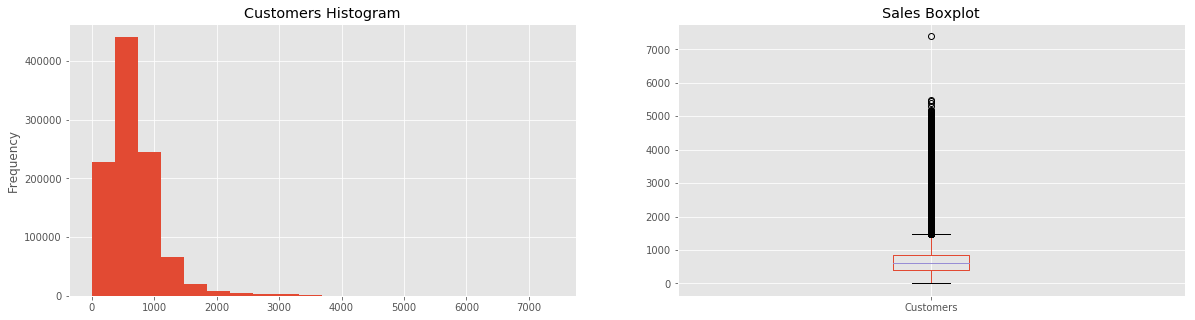

In [10]:
f, ax = plt.subplots(1,2, figsize = (20, 5))

train_df.Customers.plot(kind = "hist", title = "Customers Histogram", bins = 20, ax = ax[0])
train_df.Customers.plot.box(title = "Sales Boxplot", ax = ax[1])

In [11]:
#Seems to had a great sortiment on 22th of January 2013. They hit the record of customers. 
train_df[(train_df.Customers > 6000)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
993496,817,2,2013-01-22,27190,7388,1,1,0,0


Lets look at the **open** variable

In [12]:
print("In 3 years, different stores where", train_df[(train_df.Open == 0)].count()[0], "times closed")
print("From this days,", train_df[(train_df.Open == 0) & 
         ((train_df.StateHoliday == "a") | 
         (train_df.StateHoliday == "b") | 
         (train_df.StateHoliday == "c"))].count()[0], "times the stores were closed because of holidays")
print(train_df[(train_df.Open == 0) & (train_df.SchoolHoliday == 1)].count()[0], "times, some stores were closed because of school holiday")
print("The stores were in some sundays opend ->", train_df[(train_df.Open == 1) & (train_df.DayOfWeek == 7)].count()[0], "times")
print("However,", train_df[(train_df.Open == 0) & ((train_df.StateHoliday == "0") | (train_df.StateHoliday == 0)) & (train_df.SchoolHoliday == 0)].count()[0], 
      "times, the stores were closed for no reason (No Holidays o Sunday)")

In 3 years, different stores where 172817 times closed
From this days, 30140 times the stores were closed because of holidays
18264 times, some stores were closed because of school holiday
The stores were in some sundays opend -> 3593 times
However, 139610 times, the stores were closed for no reason (No Holidays o Sunday)


In [13]:
print("""Rossman described clearly, that they were undergoing refurbishments sometimes and had to close. 
      Most probably those were the times this event was happening. 
      However, we dont want to have those obsvervations in our dataset, when predicting. So lets delete those days after we finished 
      our analysis""")


Rossman described clearly, that they were undergoing refurbishments sometimes and had to close. 
      Most probably those were the times this event was happening. 
      However, we dont want to have those obsvervations in our dataset, when predicting. So lets delete those days after we finished 
      our analysis


What about **Promotion**

In [14]:
print(round((train_df.Promo[train_df.Promo == 1].count() / train_df.shape[0] * 100), 2), "% of the time, has been promotions made")

38.15 % of the time, has been promotions made


Now lets take a look at **StateHoliday** Variable.

In [15]:
# StateHoliday is not a continous number. 
train_df.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [16]:
# StateHoliday is a string and I for me is not so important to know what kind of holiday (a, b or c). I will convert it into 0 and 1, by creating a new variable
train_df["StateHoliday_cat"] = train_df["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})
train_df.StateHoliday_cat.count()

1017209

In [17]:
# let get rid of the StateHoliday column and use only the new one
train_df = train_df.drop("StateHoliday", axis = 1)
train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_cat
1017204,1111,2,2013-01-01,0,0,0,0,1,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1
1017208,1115,2,2013-01-01,0,0,0,0,1,1


In [18]:
#lets delete the times, where the stores were opened with no sales because of days in inventory.
train_df = train_df.drop(train_df[(train_df.Open == 0) & (train_df.Sales == 0)].index)
train_df = train_df.reset_index(drop = True) # to ge the indexes back to 0, 1, 2,etc.

train_df.isnull().all() #to check for NaNs

Store               False
DayOfWeek           False
Date                False
Sales               False
Customers           False
Open                False
Promo               False
SchoolHoliday       False
StateHoliday_cat    False
dtype: bool

# Let's go ahead with the **store** analysis

In [19]:
store_df.head().append(store_df.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [20]:
#how may missing data do we have in %:
100- (store_df.count() / store_df.shape[0] * 100)

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

In [21]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Lets start with the missing data. The first one is **CompetitionDistance**

the median is 2325.0 and mean is 5404.901079136691


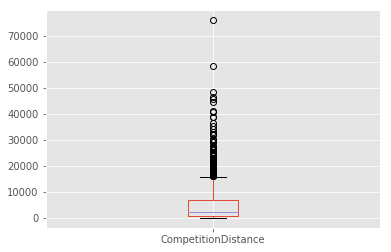

In [22]:
store_df.CompetitionDistance.plot.box() #let me see the outliers, so we can choose between mean and median to fill the NaNs
print("the median is", store_df.CompetitionDistance.median(), "and mean is", store_df.CompetitionDistance.mean())

In [23]:
print("Since we have here some outlier, its better to input the median value to those few missing values.")
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median(), inplace = True)

Since we have here some outlier, its better to input the median value to those few missing values.


Next. What about **CompetitionOpenSinceMonth**  and **CompetitionOpenSinceYear**.

In [24]:
#The missing values, are not there, because the stores had no competition. So I would suggest to fill the missing values with zeros.
store_df["CompetitionOpenSinceMonth"].fillna(0, inplace = True)
store_df["CompetitionOpenSinceYear"].fillna(0, inplace = True)

Neeeext. Lets look at the promotions since Week and year and interval.

In [25]:
store_df.groupby(by = "Promo2", axis = 0).count() 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Promo2,,,,,,,,,
0,544,544,544,544,544,544,0,0,0
1,571,571,571,571,571,571,571,571,571


In [26]:
# so if no promo has been made, then we should replace the NaN from Promo since Week and Year with zero
store_df["Promo2SinceWeek"].fillna(0, inplace = True)
store_df["Promo2SinceYear"].fillna(0, inplace = True)
store_df["PromoInterval"].fillna(0, inplace = True)

store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


# So far, so good. Now lets **merge the files: stores and training,** so we can go on with our analysis.

In [27]:
train_store_df = pd.merge(train_df, store_df, how = "left", on = "Store")
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 18 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Date                         844392 non-null object
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64
Promo                        844392 non-null int64
SchoolHoliday                844392 non-null int64
StateHoliday_cat             844392 non-null int64
StoreType                    844392 non-null object
Assortment                   844392 non-null object
CompetitionDistance          844392 non-null float64
CompetitionOpenSinceMonth    844392 non-null float64
CompetitionOpenSinceYear     844392 non-null float64
Promo2                       844392 non-null int64
Promo2SinceWeek              844392 non-null float64
Promo2SinceYear              844392 non-null float64
PromoInte

First. I am curious about the** store types**. So lets compare the stores by Sales, Customers, etc.

In [28]:
train_store_df["Avg_Customer_Sales"] = train_store_df.Sales / train_store_df.Customers

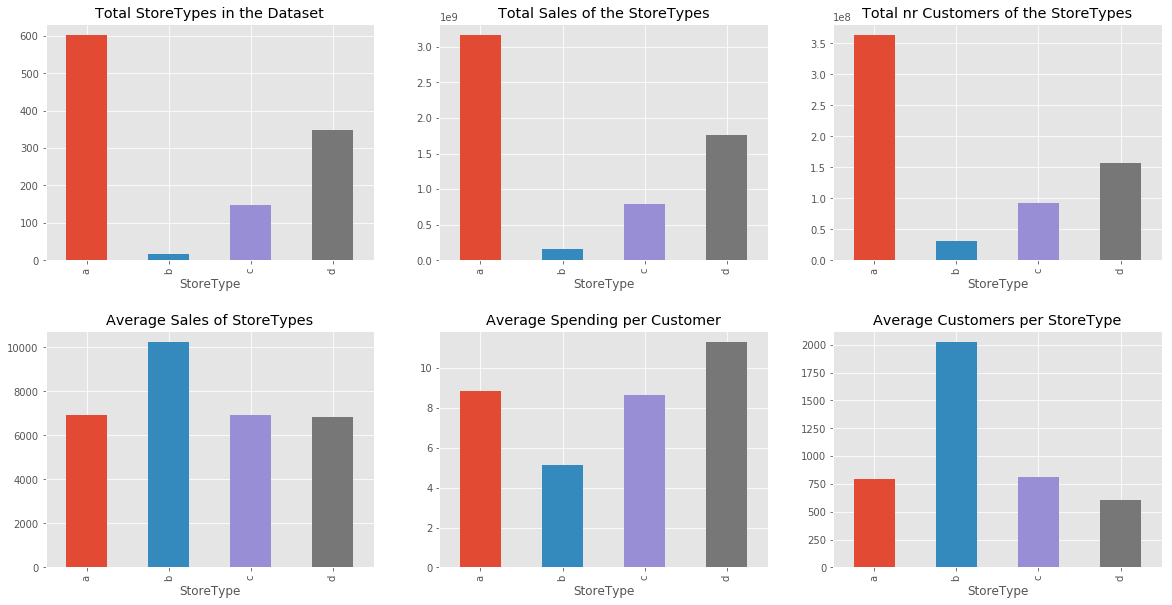

In [29]:
f, ax = plt.subplots(2, 3, figsize = (20,10))

store_df.groupby("StoreType")["Store"].count().plot(kind = "bar", ax = ax[0, 0], title = "Total StoreTypes in the Dataset")
train_store_df.groupby("StoreType")["Sales"].sum().plot(kind = "bar", ax = ax[0,1], title = "Total Sales of the StoreTypes")
train_store_df.groupby("StoreType")["Customers"].sum().plot(kind = "bar", ax = ax[0,2], title = "Total nr Customers of the StoreTypes")
train_store_df.groupby("StoreType")["Sales"].mean().plot(kind = "bar", ax = ax[1,0], title = "Average Sales of StoreTypes")
train_store_df.groupby("StoreType")["Avg_Customer_Sales"].mean().plot(kind = "bar", ax = ax[1,1], title = "Average Spending per Customer")
train_store_df.groupby("StoreType")["Customers"].mean().plot(kind = "bar", ax = ax[1,2], title = "Average Customers per StoreType")

plt.subplots_adjust(hspace = 0.3)
plt.show()

As we can see from the graphs, the StoreType A has the most stores, sales and customers. 
However the StoreType D has the best averages spendings per customers. StoreType B, with only 17 stores has the most average customers. 

Lets check the **Assortments**

So only the StoreType B has all assortments. I think thats why they are performing so good. Maybe this StoreType has more sales area.
      The assortment C is a good one, because the StoreType D has the best average customer spending.


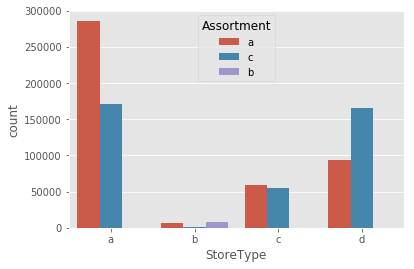

In [30]:
sns.countplot(data = train_store_df, x = "StoreType", hue = "Assortment", order=["a","b","c","d"]) 
print("""So only the StoreType B has all assortments. I think thats why they are performing so good. Maybe this StoreType has more sales area.
      The assortment C is a good one, because the StoreType D has the best average customer spending.""")

plt.show()

Lets go ahead with the **promotions**

In [31]:
train_store_df.Date = train_store_df.Date.astype("datetime64[ns]")

train_store_df["Month"] = train_store_df.Date.dt.month
train_store_df["Year"] = train_store_df.Date.dt.year
train_store_df["Day"] = train_store_df.Date.dt.day

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


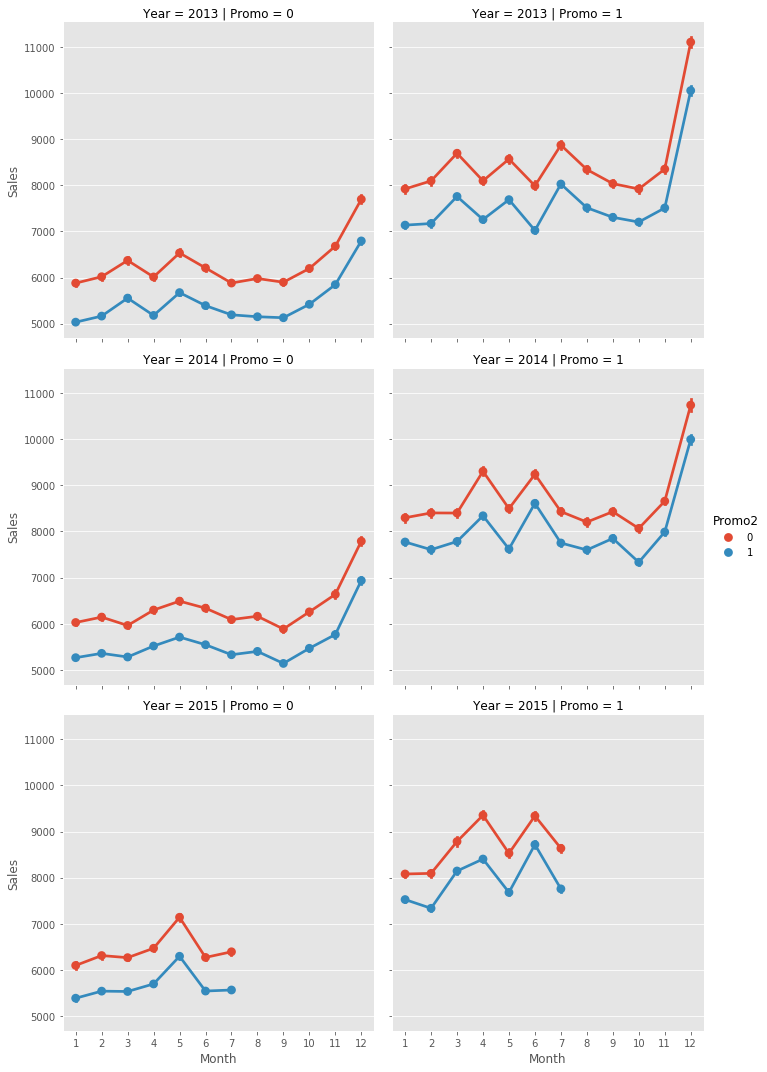

In [32]:
sns.factorplot(data = train_store_df, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
             )
# So, of course, if the stores are having promotion the sells are higher.
# Overall the store promotions sellings are also higher than the seasionality promotions (Promo2). However I can't see no yearly trend. 

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


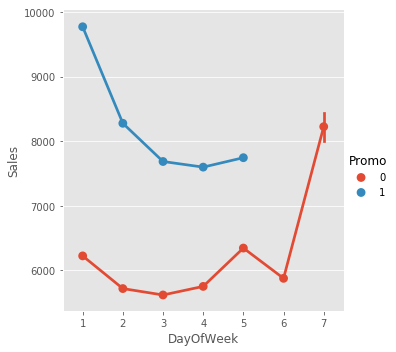

In [33]:
sns.factorplot(data = train_store_df, x = "DayOfWeek", y = "Sales", hue = "Promo")

In [34]:
print("""So, no promotion in the weekend. However, the sales are very high, if the stores have promotion. 
The Sales are going crazy on Sunday. No wonder.""")
print("There are", train_store_df[(train_store_df.Open == 1) & (train_store_df.DayOfWeek == 7)].Store.unique().shape[0], "stores opend on sundays")    


So, no promotion in the weekend. However, the sales are very high, if the stores have promotion. 
The Sales are going crazy on Sunday. No wonder.
There are 33 stores opend on sundays


Let's see the trends on a yearly basis.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


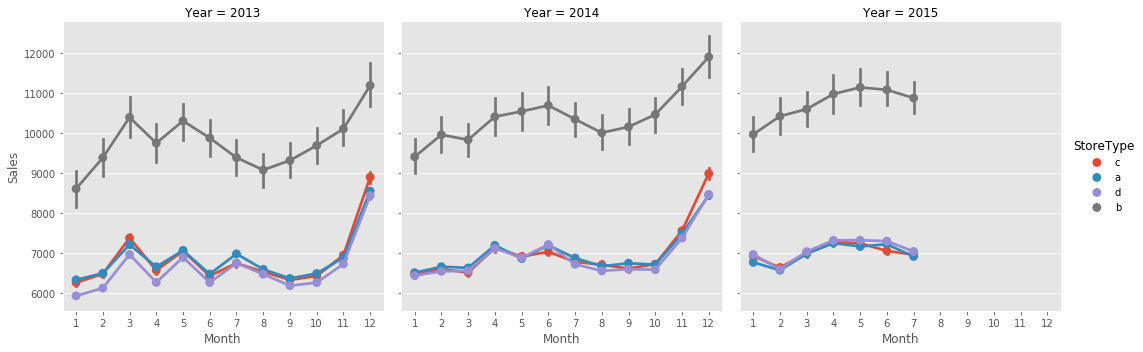

In [35]:
sns.factorplot(data = train_store_df, x = "Month", y = "Sales", col = "Year", hue = "StoreType")
# Yes, we can see a seasonalities, but not trends. The sales stays constantly yearly. 

What about the **Competition Distance**. What kind of inpact does this have on the sales.

In [36]:
train_store_df.CompetitionDistance.describe()
# The obsverations are continous numbers, so we need to convert them into a categories. Lets a create a new variable.
train_store_df["CompetitionDistance_Cat"] = pd.cut(train_store_df["CompetitionDistance"], 5)

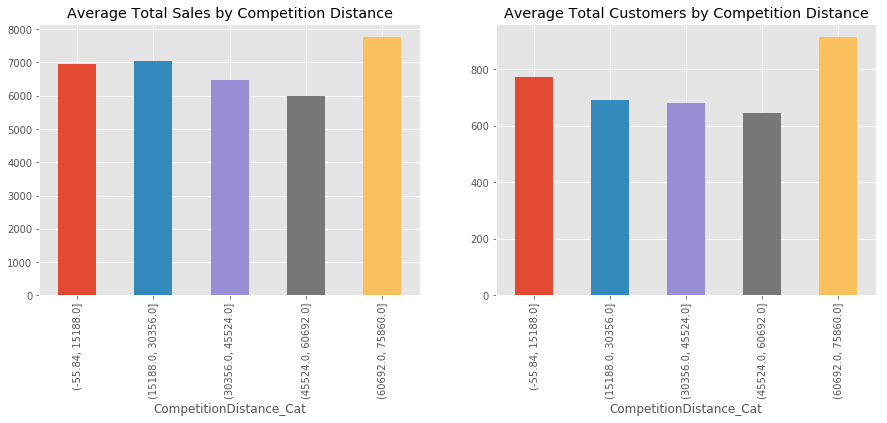

In [37]:
f, ax = plt.subplots(1,2, figsize = (15,5))

train_store_df.groupby(by = "CompetitionDistance_Cat").Sales.mean().plot(kind = "bar", title = "Average Total Sales by Competition Distance", ax = ax[0])
train_store_df.groupby(by = "CompetitionDistance_Cat").Customers.mean().plot(kind = "bar", title = "Average Total Customers by Competition Distance", ax = ax[1])

# It is pretty clear. If the competions is very far away, the stores are performing better (sales and customers)

**Lets go with the correlation graph.**

In [38]:
# first we have to convert the variables to categories, bevor we convert them to codes.

# train_store_df["Promo"] = train_store_df["Promo"].astype("category") # it's already numerica
# train_store_df["SchoolHoliday"] = train_store_df["SchoolHoliday"].astype("category") # it's already numerica
train_store_df["StoreType"] = train_store_df["StoreType"].astype("category")
train_store_df["Assortment"] = train_store_df["Assortment"].astype("category")
# train_store_df["Promo2"] = train_store_df["Promo2"].astype("category") # it's already numerica
train_store_df["PromoInterval"] = train_store_df["PromoInterval"].astype("category")

train_store_df["StoreType_cat"] = train_store_df["StoreType"].cat.codes
train_store_df["Assortment_cat"] = train_store_df["Assortment"].cat.codes
train_store_df["PromoInterval_cat"] = train_store_df["Assortment"].cat.codes

train_store_df["StateHoliday_cat"] = train_store_df["StateHoliday_cat"].astype("float")
train_store_df["StoreType_cat"] = train_store_df["StoreType_cat"].astype("float")
train_store_df["Assortment_cat"] = train_store_df["Assortment_cat"].astype("float")
train_store_df["PromoInterval_cat"] = train_store_df["PromoInterval_cat"].astype("float")

In [39]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 26 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Date                         844392 non-null datetime64[ns]
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64
Promo                        844392 non-null int64
SchoolHoliday                844392 non-null int64
StateHoliday_cat             844392 non-null float64
StoreType                    844392 non-null category
Assortment                   844392 non-null category
CompetitionDistance          844392 non-null float64
CompetitionOpenSinceMonth    844392 non-null float64
CompetitionOpenSinceYear     844392 non-null float64
Promo2                       844392 non-null int64
Promo2SinceWeek              844392 non-null float64
Promo2SinceYear              844392 non-null flo

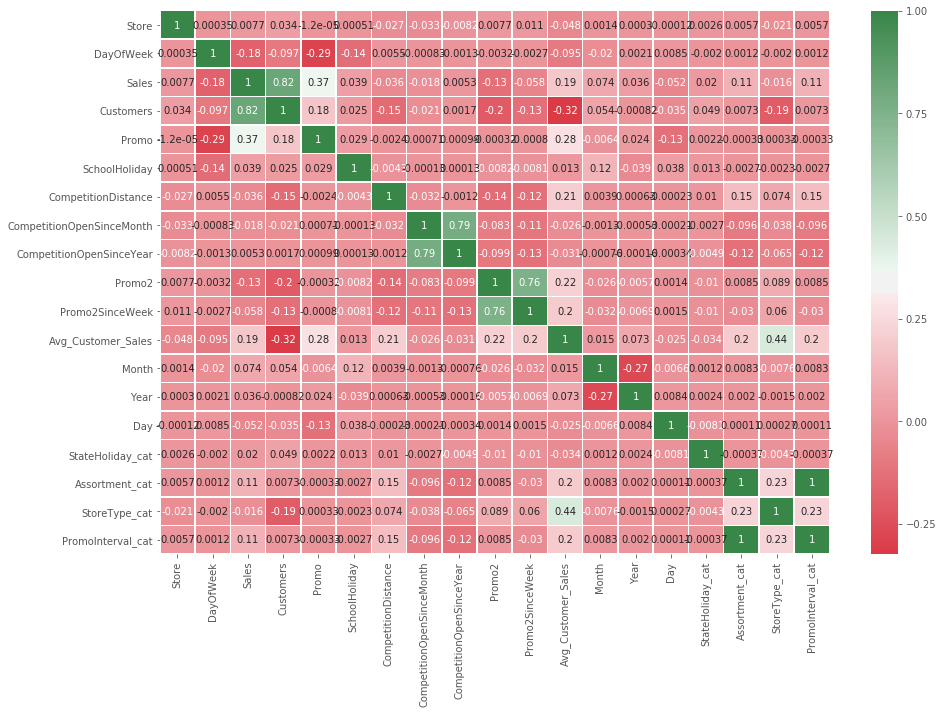

In [40]:
df_correlation = train_store_df[["Store", "DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "CompetitionDistance", 
                                 "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Avg_Customer_Sales", 
                                 "Month", "Year", "Day", "StateHoliday_cat", "Assortment_cat", "StoreType_cat", "PromoInterval_cat"]]


f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(),ax = ax, annot=True, cmap=sns.diverging_palette(10, 133, as_cmap=True), linewidths=0.5)

Following correlations we can confirm from the graph above: 
* Customer vs Sales (0.82) 
* Promo vs Sales (0,82)
* Avg_Customer_Sales vs Promo (0,28)
* Avg_Customer_Sales vs Promo2 (0,22)
* StoreTypve vs Avg_Customer_Sales (0,44)

# My conclusion of the analysis: 


* StoreType A has the most sells and customers.
* StoreType B has the lowest Average Sales per Customer. So i think customers visit this type only for small things.
* StoreTybe D had the highest buyer cart. 
* Promo runs only in weekdays.
* Promo2 doesnt seems to be correlated to any significant change in the sales amount.
* Customers tends to buy more on Monday, when there's promotion running (Promo) and on Sundays, when there is no promotion at all. 
* At this point, I dont see any yearly trends. Only seasonal patterns. 


Lets go ahead with forecasting. I will try different Models, like ARIMA, Prophet, RandomForest and XGBoost

# ARIMA Forecasting

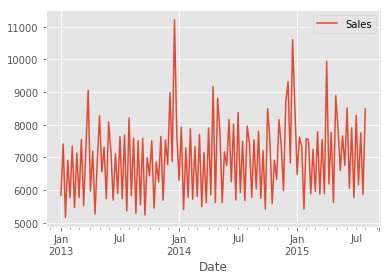

In [41]:
ts_arima = train_store_df.set_index("Date").resample("W").mean() #set the index to date and resample it by summing to monthly values
ts_arima = ts_arima[["Sales"]]
ts_arima.plot()

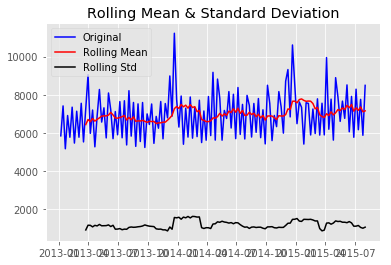

In [42]:
# Les see if we have stationary or non-stationary time series

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
#     #Perform Dickey-Fuller test:
#     print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
    
test_stationarity(ts_arima)

hmm.. **the script is dosent work well, so i cant check the critical value and test statistic.**
FYI: if the test statistic is greater than the critcal value, then we can not reject the null hypothesis, the series is stationary. That said it is still non-stationary. If you increase the i value in ARIMA model, perhaps above condition may meet and you may get the good forecast values

As we can see from the graph, we are dealing with a seasonal Time Series. So I need to find the right parameters for the ARIMA Model as ARIMA(p,d,q)(P,D,Q)s. Here (p,d,q) are the non-seasonal parameter, while (P,D,Q) follow the same defintion, but are for the seasonal component of the series. The term s, is the periodicity (4 for the quarerly periods, 12 for yearly periods, etc.)

* p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

In [43]:
import warnings
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Let's begin by generating the various combination of parameters that we wish to assess:

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Lets iterate through some combinations of parameters and use the SARIMAX function to get the AIC Score. The lowes AIC value is the optimal option for our model

In [44]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2758.376473500445
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2442.2712635578914
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2182.959421090318
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1929.3167714924248
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2203.743698132474
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2162.6354053663676
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1954.4352162224814
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1930.2161165052075
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2668.756620337808
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2344.260669468212
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2157.137284565173
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1901.4242538046506
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2198.5555382380826
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2139.1230506086586
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1942.8377682349335
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1901.3130221465137
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2399.53422109695
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2180.337477867119
A

In [45]:
# this is the optimal paramater for our model: ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1847.5087433770632

mod = sm.tsa.statespace.SARIMAX(ts_arima,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5577      0.090     -6.229      0.000      -0.733      -0.382
ma.L1         -0.7300      0.060    -12.221      0.000      -0.847      -0.613
ar.S.L12      -0.1579      0.133     -1.186      0.236      -0.419       0.103
ma.S.L12      -1.0328      0.663     -1.559      0.119      -2.331       0.266
sigma2      1.199e+06   8.76e+05      1.370      0.171   -5.17e+05    2.92e+06


* Lets focus only on **coef**. This column shows the importance (weight) of each feature and how each one impacts the time series. 
* The **P>|z|** column informs us of the significance of each feature. Here, weach weight has a p-value higher then 0, 


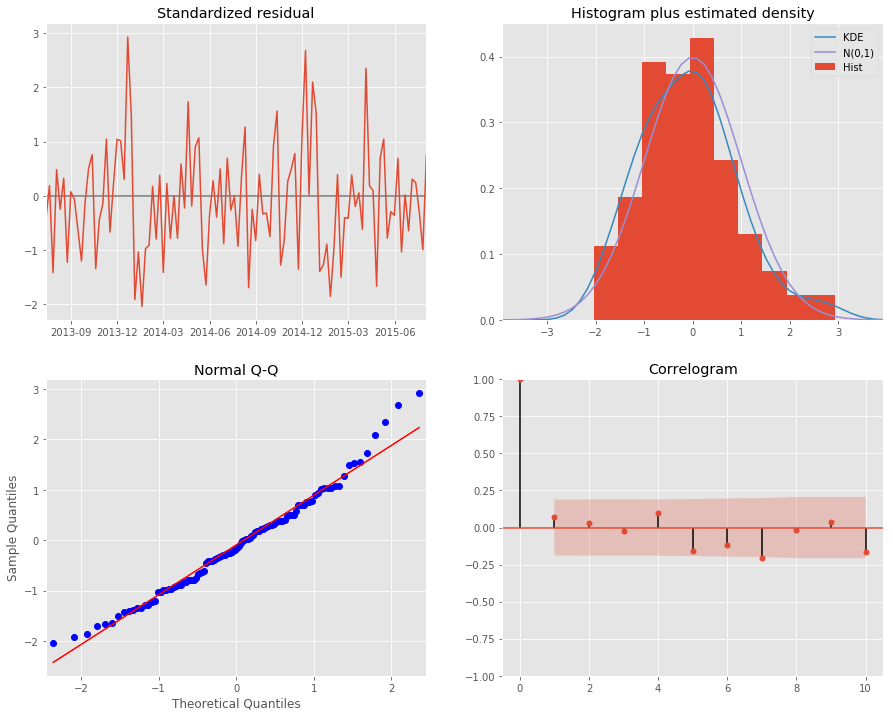

In [46]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

* In the top right plot, we see that the red KDE line don't follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

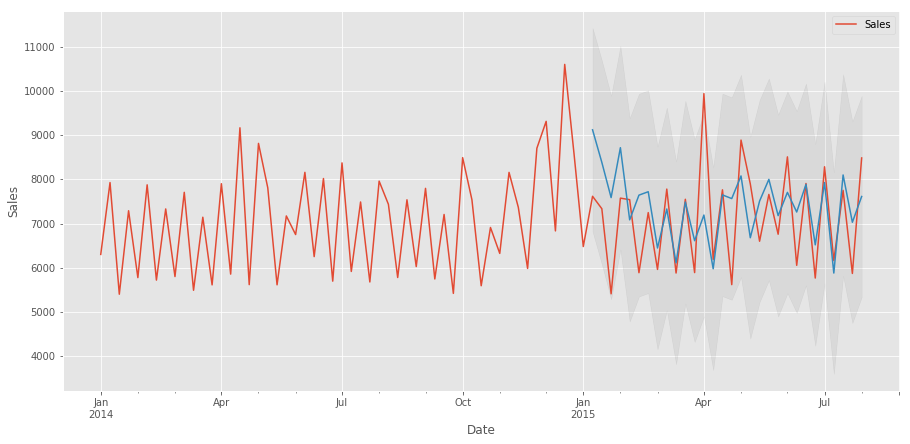

RMS: 1060.2381339654555


In [47]:
# Lets go ahead with validating forecasts

pred = results.get_prediction(start = pd.to_datetime("2015-01-11"), dynamic = False) 
# lets start the fc to start from 1.11.2015. 
# The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.
pred_ci = pred.conf_int() # Get confidence intervals of forecasts

ax = ts_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead FC", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

# -----------
#  extract the predicated and true values of our time series
ts_forecasted = pred.predicted_mean
ts_truth = ts_arima["2015-01-11":]
# to use, in my case, the mean squared error:
rms_arima = sqrt(mean_squared_error(ts_truth, ts_forecasted))
print("RMS:", rms_arima) 

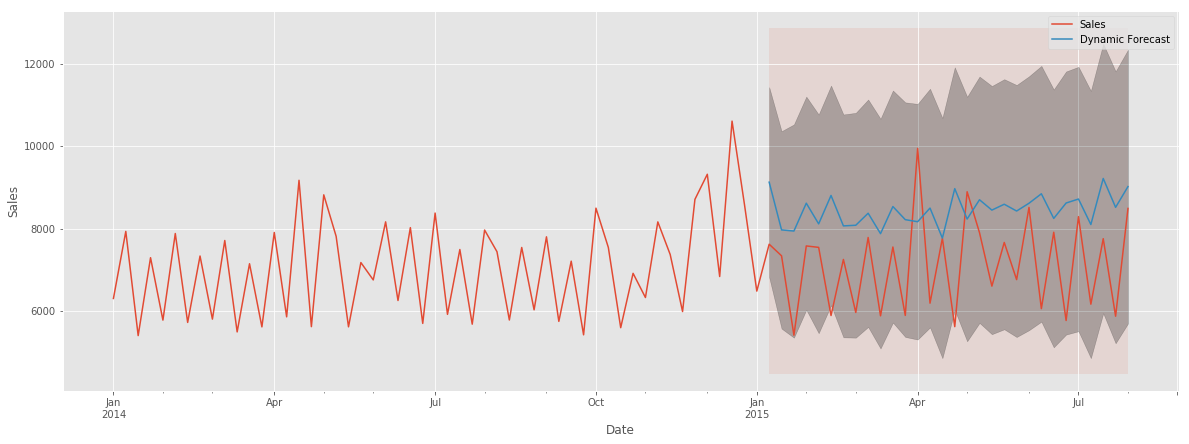

RMS: 1749.8694060463952


In [48]:
# lets try a dynamic forecast. In this case we will use information from the time series up to a certain point, to generate future values.
pred_dynamic = results.get_prediction(start = pd.to_datetime("2015-01-11"), dynamic = True, full_results = True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = ts_arima["2014":].plot(label = "observed", figsize = (20, 7))
pred_dynamic.predicted_mean.plot(label ="Dynamic Forecast", ax = ax)

ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1], color ="k", alpha = 0.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime("2015-01-11"), ts_arima.index[-1],
                alpha = 0.1, zorder =-1)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend()
plt.show()

# -----------
#  extract the predicated and true values of our time series
ts_forecasted = pred_dynamic.predicted_mean
ts_truth = ts_arima["2015-01-11":]
# to use, in my case, the mean squared error:
rms_arima_dynamic = sqrt(mean_squared_error(ts_truth, ts_forecasted))
print("RMS:", rms_arima_dynamic) 

Hmm.. the FC Acurracy is not getting better

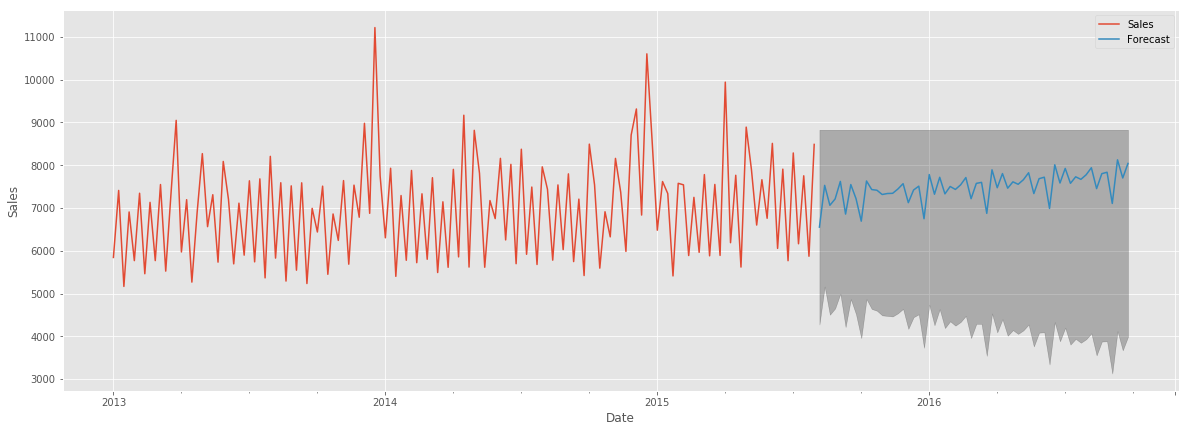

In [49]:
pred_uc = results.get_forecast(steps = 60) # lets get a forecast for the next few periods
pred_ci = pred_uc.conf_int() # Get confidence intervals of forecasts

ax = ts_arima.plot(label = "observed", figsize = (20,7))
pred_uc.predicted_mean.plot(ax = ax, label = "Forecast")
ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0],
               pred_ci.iloc[0, 1], color = "k", alpha = 0.25)
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend()
plt.show()


**Let us check another regression forecast -> **

# Prophet
https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [50]:
from fbprophet import Prophet

In [51]:
# I want to create a new dataframe for this model.
ts_prophet = train_store_df.drop(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo',
       'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval', 'Avg_Customer_Sales', 'Month', 'Year', 'Day',
       'CompetitionDistance_Cat', 'StoreType_cat', 'Assortment_cat',
       'PromoInterval_cat', "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)

ts_prophet.head()

,Date,Sales,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263,1,0.0
1,2015-07-31,6064,1,0.0
2,2015-07-31,8314,1,0.0
3,2015-07-31,13995,1,0.0
4,2015-07-31,4822,1,0.0


In [52]:
# as I understand from the documentation, the variables should have a specific names
ts_prophet = ts_prophet.rename(columns = {"Date": "ds",
                          "Sales": "y"})

ts_prophet.tail()


,ds,y,SchoolHoliday,StateHoliday_cat
844387,2013-01-01,3375,1,1.0
844388,2013-01-01,10765,1,1.0
844389,2013-01-01,5035,1,1.0
844390,2013-01-01,4491,1,1.0
844391,2013-01-01,5961,1,1.0


In [53]:
# In prophet we can also model the holidays. so lets go for it.

state_dates = ts_prophet[(ts_prophet.StateHoliday_cat == 1)].loc[:, "ds"].values
school_dates = ts_prophet[(ts_prophet.SchoolHoliday == 1)].loc[:, "ds"].values

state = pd.DataFrame({"holiday": "state_holiday", 
                     "ds": pd.to_datetime(state_dates)})
school = pd.DataFrame({"holiday": "school_holiday",
                      "ds": pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [54]:
ts_prophet = ts_prophet.drop(["SchoolHoliday", "StateHoliday_cat"], axis = 1) # we dont need them anymore.

In [55]:
# it takes just too long to fit the model with a daily time series, so lets make it weekly.
ts_week_prophet = ts_prophet.set_index("ds").resample("W").sum()
ts_week_prophet_train = ts_week_prophet["2013-01-01": "2015-01-11"] #I will slice the dataframe, so we can have some testing data 
ts_week_prophet_train = ts_week_prophet_train.reset_index()
ts_week_prophet = ts_week_prophet.reset_index() # here are all the weekly data

holidays_week = holidays.set_index("ds").resample("W").min()
holidays_week = holidays_week.dropna(axis = 0)
# holidays_week.holiday.fillna(0, inplace = True)
holidays_week = holidays_week.reset_index()

In [56]:
# help(Prophet)

In [57]:
# lets fit the model
prophet = Prophet(holidays = holidays) # holidays = holidays_week
# prophet = Prophet(interval_width = 0.80, holidays = holidays, weekly_seasonality=True, daily_seasonality=False) # the default uncertainty is 80 %
prophet.fit(ts_week_prophet_train)
print("done")

future = prophet.make_future_dataframe(periods = 52, freq = "W") # here we are extending our dataframe with the dates for which a prediction is to be made.
forecast = prophet.predict(future) # with predict method I asign each row in future dates a predicted value, which it names yhat

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() # We have a new dataframe, which includes, the forecast and the uncertainity invervals.


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


done


,ds,yhat,yhat_lower,yhat_upper
153,2015-12-13,5.021805e+07,4.012733e+07,5.933237e+07
154,2015-12-20,4.824790e+07,3.924426e+07,5.787674e+07
155,2015-12-27,4.310914e+07,3.363574e+07,5.177857e+07
156,2016-01-03,3.832571e+07,2.948974e+07,4.735263e+07
157,2016-01-10,3.656034e+07,2.711468e+07,4.580066e+07


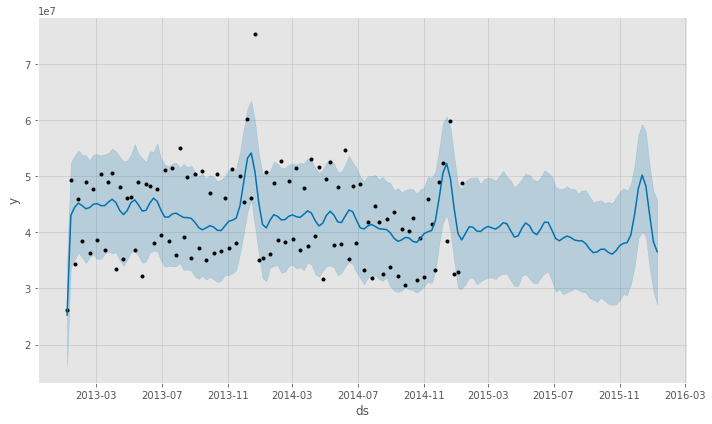

In [58]:
fig1 = prophet.plot(forecast) #plot the results for the forecast time.

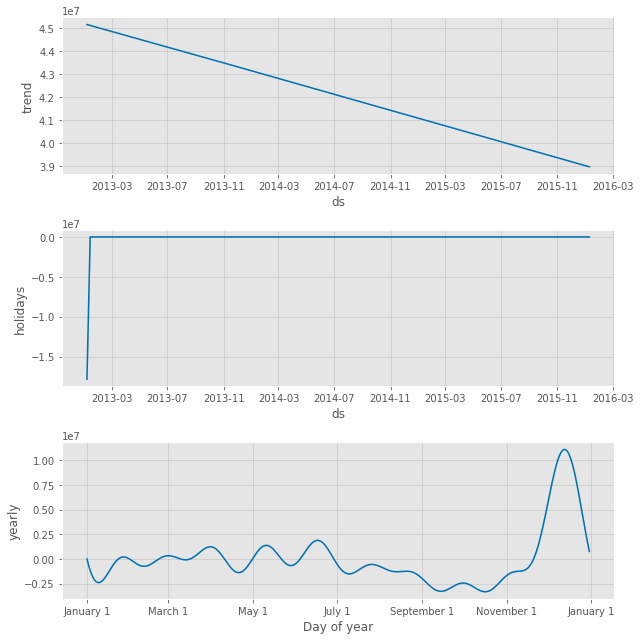

In [59]:
# with this method we can see the components (trend, yearly seasonality and weekly seasonality of the time series.).
fig2 = prophet.plot_components(forecast)

Now I want to see the real truth data and the forecasted data.

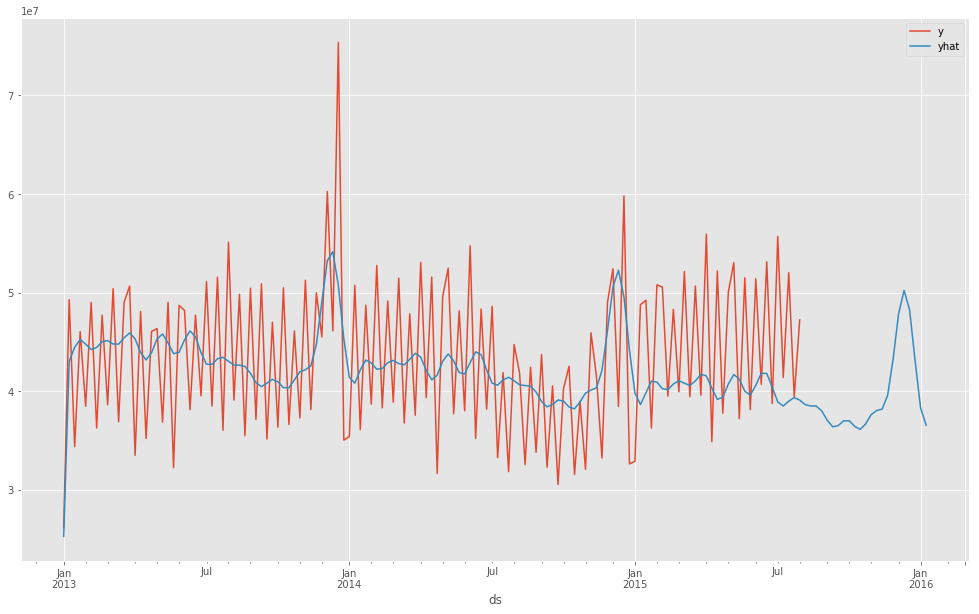

In [60]:
fc_week_prophet = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]] # create a df with only the importan variables
fc_week_prophet = fc_week_prophet.merge(ts_week_prophet, how = "left", on = "ds") #add the original data to the fc frame, so we can compare 
fc_week_prophet = fc_week_prophet.set_index("ds") # make a time series index

plt.figsize=(10,20)
fc_week_prophet["y"].plot(figsize=(17,10))
fc_week_prophet["yhat"].plot()

plt.legend()
plt.show()

In [61]:
# y_prophet = fc_week_prophet["y"][: "2015-08-02"]
# yhat_prophet = fc_week_prophet["yhat"][: "2015-08-02"]

# rms_prophet = sqrt(mean_squared_error(fc_week_prophet["y"], fc_week_prophet["yhat"]))
# print("RMS:", rms_prophet) 

**To-Do in progress:** calculate the RMS

# Random Forest Regression

Before we can start with fit and train our model, we need to do some feature engineering. 

The CompetitionOpen since...  variables have the same meaning. So lets convert them into one variable that we call CompetitionOpenSince. It makes it easier for the algorithm to understand the pattern and creates less branches and thus complex trees.

In [62]:
train_store_df["CompetitionOpenSince"] = np.where((train_store_df["CompetitionOpenSinceMonth"] == 0) & (train_store_df["CompetitionOpenSinceYear"] == 0), 
                                                0,(train_store_df.Month - train_store_df.CompetitionOpenSinceMonth) + (12 *(train_store_df.Year - train_store_df.CompetitionOpenSinceYear)))

# lets drop the variables
train_store_df = train_store_df.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)

In [63]:
# lets drop few variables, that either or not numeric or we dont need them anymore
# lets create a new data frame for this model
ts_rfr = train_store_df.copy()
ts_rfr = train_store_df.drop(["Date","StoreType", "Assortment", "PromoInterval", "CompetitionDistance_Cat"], axis = 1) #dop this columns, as we already have them in categories
# ts_rfr = pd.get_dummies(ts_rfr, columns = ["Assortment_cat", "StoreType_cat", "PromoInterval_cat"], prefix = ["is_Assortment", "is_StoreType", "is_PromoInterval"]) # create dummies

**Let's go ahead and develop the Model**

I will use now only the training Dataset. 

In [80]:
from sklearn import model_selection
from sklearn import metrics

features = ts_rfr.drop(["Customers", "Sales", "Avg_Customer_Sales"], axis = 1)
target = ts_rfr["Sales"]

X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(features, target, test_size = 0.20, random_state = 15) 
# I call here train_test_set which is  divided 80% and 20% validation
print(X_train.shape, X_train_test.shape, y_train.shape, y_train_test.shape)

(675513, 17) (168879, 17) (675513,) (168879,)


Lets try our **RandomForestRegressor**

In [65]:
# Try different numbers of n_estimators - this will take a minute or so
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs=-1)
# estimators = np.arange(10, 200, 10)
# scores = []
# for n in estimators:
#     model.set_params(n_estimators=n)
#     model.fit(X_train, y_train)
#     scores.append(model.score(X_train_test, y_train_test))
# plt.title("Effect of n_estimators")
# plt.xlabel("n_estimator")
# plt.ylabel("score")
# plt.plot(estimators, scores)

# #another script that takes toooo long, to find the right parameters for RFR
# params = {'max_depth':(4,6,8,10,12,14,16,20),
#          'n_estimators':(4,8,16,24,48,72,96,128),
#          'min_samples_split':(2,4,6,8,10)}
# #scoring_fnc = metrics.make_scorer(rmspe)
# #the dimensionality is high, the number of combinations we have to search is enormous, using RandomizedSearchCV 
# # is a better option then GridSearchCV
# grid = model_selection.RandomizedSearchCV(estimator=rfr,param_distributions=params,cv=10) 
# #choosing 10 K-Folds makes sure i went through all of the data and didn't miss any pattern.(takes time to run but is worth doing it)
# grid.fit(X_train, y_train)


In [81]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(X_train, y_train)
yhat = rfr.predict(X_train_test)
rms_rfr = sqrt(mean_squared_error(y_train_test, yhat))
print("RMS:", rms_rfr) 

RMS: 979.5069876615964


In order to understand better what happened when we ran our randomforest regressor, here is a chart that represents, the importance and role that each variable that i decided to include played in this learning process:

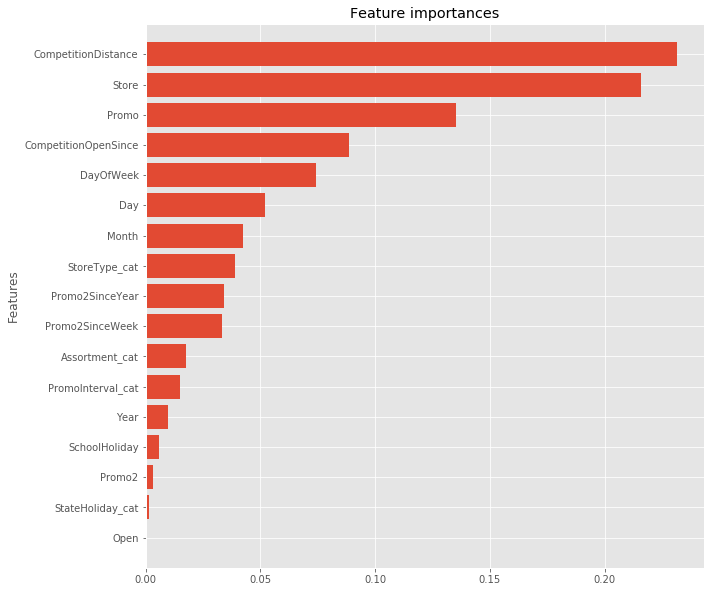

In [83]:
importances = rfr.feature_importances_
std = np.std([rfr.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)
palette1 = itertools.cycle(sns.color_palette())
# Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
# Plot the feature importances of the forest

plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
            color=[next(palette1)], align="center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()

**To-Do in progress**: y_train vs y_train_test plot is missing.

# XGBoost

In [86]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [87]:
import xgboost as xgb

param = {'max_depth':10, # maximum depth of a tree
         "booster": "gbtree",   # use tree based models 
         'eta':1, # learning rate
         'silent':1, # silent mode
         'objective':'reg:linear', # for linear regression
#          "seed": 10,   # Random number seed
#          "subsample": 0.9,    # Subsample ratio of the training instances
        }

num_round = 100 #how many boosting rounds

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_train_test, y_train_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

xgboost = xgb.train(param, dtrain, num_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)
         
# make prediction
preds = xgboost.predict(dtest)

# model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
#   early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:2274.79	eval-rmse:2280.63	train-rmspe:nan	eval-rmspe:nan
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:2150.56	eval-rmse:2172.12	train-rmspe:nan	eval-rmspe:nan
[2]	train-rmse:1908.5	eval-rmse:1936.47	train-rmspe:nan	eval-rmspe:nan
[3]	train-rmse:1790.51	eval-rmse:1818.59	train-rmspe:nan	eval-rmspe:nan
[4]	train-rmse:1684.42	eval-rmse:1714.7	train-rmspe:nan	eval-rmspe:nan
[5]	train-rmse:1444.02	eval-rmse:1478.75	train-rmspe:nan	eval-rmspe:nan
[6]	train-rmse:1334.71	eval-rmse:1370.92	train-rmspe:nan	eval-rmspe:nan
[7]	train-rmse:1269.45	eval-rmse:1309.72	train-rmspe:nan	eval-rmspe:nan
[8]	train-rmse:1225.19	eval-rmse:1271.76	train-rmspe:nan	eval-rmspe:nan
[9]	train-rmse:1173.67	eval-rmse:1221.34	train-rmspe:nan	eval-rmspe:nan
[10]	train-rmse:1085.94	eval-rmse:1136.87	train-rmspe:nan	eval-rmspe:nan
[11]	train-rmse:1026.89	eval-rmse:1082.01	train-rmspe:nan	eval-

In [88]:
rms_xgboost = sqrt(mean_squared_error(y_train_test, preds))
print("RMS:", rms_xgboost) 

RMS: 841.9207317999857


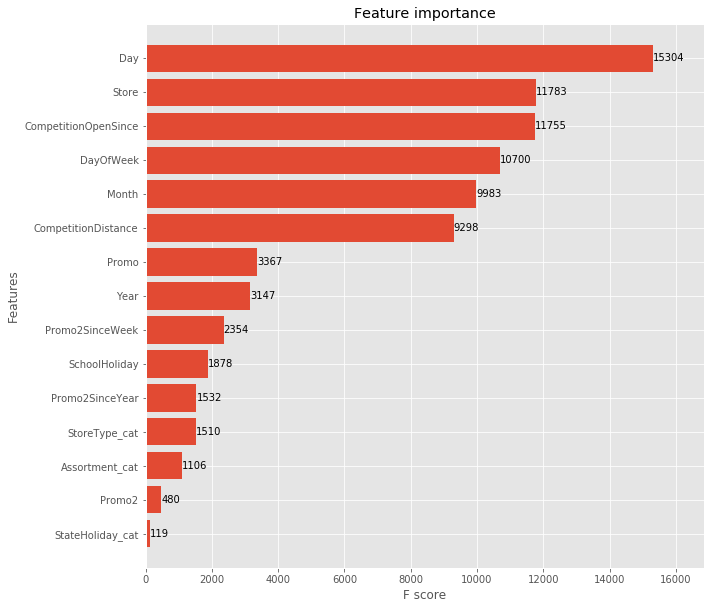

In [89]:
# Lets see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [91]:
print("now lets see the scores togher")

model_errors = pd.DataFrame({
    "Model": ["SARIMAX", "SARIMAX Dynamic", "Random Forest Regression", "XGBoost"],
    "Score": [rms_arima, rms_arima_dynamic, rms_rfr, rms_xgboost]
})

model_errors.sort_values(by = "Score", ascending = True)

now lets see the scores togher


,Model,Score
3,XGBoost,841.920732
2,Random Forest Regression,979.506988
0,SARIMAX,1060.238134
1,SARIMAX Dynamic,1749.869406


**To-Do in progress:** y vs yhat plot is missing.

# Test Dataset, if we want to submit it.

In [ ]:
# # As we are working with a decision tree based model, we need to use dummy variables instead of categorical levels. 
# # Why? Because this alters the bias of the algorithm who will favor a higher weight to the categories like 4 and deprioritize levels like 1.

# train_store_df = pd.get_dummies(train_store_df, columns = ["Assortment", "StoreType", "PromoInterval"], prefix = ["is_Assortment", "is_StoreType", "is_PromoInterval"])

In [ ]:
# test_df = pd.read_csv("../input/test.csv", parse_dates = ["Date"])
# print("The Test Dataset has", test_df.shape[0], "observations and", test_df.shape[1], "variables")

In [ ]:
# # We want to make sure that we consider all events, so lets join the test dataset with the store set.
# test_store_df = pd.merge(test_df, store_df, how = "left", on = "Store")

# print("Now we have", test_store_df.shape[0], "observations and", test_store_df.shape[1], "columns")

In [ ]:
# # Lets create and conver the variables. Just like we did with the training dataset.

# test_store_df["Month"] = test_store_df.Date.dt.month
# test_store_df["Year"] = test_store_df.Date.dt.year
# test_store_df["Day"] = test_store_df.Date.dt.day

# test_store_df["StateHoliday"] = test_store_df["StateHoliday"].astype("category")
# test_store_df["PromoInterval"] = test_store_df["SchoolHoliday"].astype("category")
# test_store_df["StoreType"] = test_store_df["StoreType"].astype("category")
# test_store_df["Assortment"] = test_store_df["Assortment"].astype("category")

# test_store_df["StateHoliday_cat"] = test_store_df["StateHoliday"].cat.codes
# test_store_df["PromoInterval_cat"] = test_store_df["PromoInterval"].cat.codes
# test_store_df["StoreType_cat"] = test_store_df["StoreType"].cat.codes
# test_store_df["Assortment_cat"] = test_store_df["Assortment"].cat.codes

# test_store_df["StateHoliday_cat"] = test_store_df["StateHoliday_cat"].astype("float")
# test_store_df["PromoInterval_cat"] = test_store_df["PromoInterval_cat"].astype("float")
# test_store_df["StoreType_cat"] = test_store_df["StoreType_cat"].astype("float")
# test_store_df["Assortment_cat"] = test_store_df["Assortment_cat"].astype("float")

# test_store_df["CompetitionOpenSince"] = np.where((test_store_df["CompetitionOpenSinceMonth"] == 0) & (test_store_df["CompetitionOpenSinceYear"] == 0), 
#                                                 0,(test_store_df.Month - test_store_df.CompetitionOpenSinceMonth) + (12 *(test_store_df.Year - test_store_df.CompetitionOpenSinceYear)))

# test_store_df["StateHoliday_cat"] = test_store_df["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})

# test_store_df = test_store_df.drop(["Date", "StateHoliday", "StoreType", "Assortment", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "PromoInterval"], axis = 1)

# # test_store_df = test_store_df.sort_index(axis = 1).reset_index("Id") #make the ID variabe as index.

# print("So we have in our training set", train_store_df.shape[1], "variables and in our testing set", test_store_df.shape[1])
# print("in the testing set, we are missing only 3 and this are: Sales, Customer and Avg Sales per Customer")

In [ ]:
# import tsfresh